# Information Theory Measures

In this notebook, I will be demonstrating some of the aspects of information theory measures.

## Data - Climate Models

In [1]:
import os, sys
cwd = os.getcwd()
source_path = f"{cwd}/../../../"
sys.path.insert(0, f'{source_path}')

import numpy as np

# Data Loaders
from src.data.climate.amip import DataDownloader, DataLoader

from src.data.climate.era5 import get_era5_data
from src.data.climate.ncep import get_ncep_data
from src.features.climate.build_features import (
    get_time_overlap, check_time_coords, regrid_2_lower_res, get_spatial_cubes, normalize_data)

from src.experiments.climate.amip_global import (
    experiment_loop_comparative, 
    experiment_loop_individual
)
# Stat Tools
from src.models.information.entropy import RBIGEstimator as RBIGENTEST
from src.models.information.mutual_information import RBIGEstimator as RBIGMIEST

from scipy import stats

import pandas as pd
import xarray as xr
from tqdm import tqdm
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
amip_data_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/raw/amip/"
era5_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/raw/era5/"
ncep_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/raw/ncep/"
results_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/results/"
fig_path = f"/home/emmanuel/projects/2020_rbig_rs/reports/figures/climate/"

## Demo Experiment

### Experimental Paams

In [3]:
class DataArgs:
    data_path = "/home/emmanuel/projects/2020_rbig_rs/data/climate/raw/amip/"
    results_path = "/home/emmanuel/projects/2020_rbig_rs/data/climate/results/amip"

class CMIPArgs:

        
    # Fixed Params
    spatial_windows = [
        1, 2,                # Spatial Window for Density Cubes
        3,4,5,6,7,8,9,10
    ]

    # Free Params
    variables = [
        'psl'               # Mean Surface Pressure
    ]
    cmip_models = [
        "inmcm4",
        "access1_0",
        "bcc_csm1_1",
        "bcc_csm1_1_m",
        "bnu_esm",
        "giss_e2_r",
        "cnrm_cm5",
        "ipsl_cm5a_lr",
        "ipsl_cm5a_mr",
        "ipsl_cm5b_lr",
        "mpi_esm_lr",
        "mpi_esm_mr",
        "noresm1_m",
    ]
    
    base_models = [
        'ncep',
        "era5"
    ]
        

### Part I - Grab Data

In [4]:
from src.data.climate.amip import get_base_model

base_dat = get_base_model(CMIPArgs.base_models[0], CMIPArgs.variables[0])
# base_dat

In [5]:
from src.data.climate.cmip5 import get_cmip5_model


cmip_dat = get_cmip5_model(CMIPArgs.cmip_models[0], CMIPArgs.variables[0])
# cmip_dat

### Part II - Regrid Data

In [6]:
base_dat, cmip_dat = regrid_2_lower_res(base_dat, cmip_dat)

assert(base_dat.shape[1] == cmip_dat.shape[1])
assert(base_dat.shape[2] == cmip_dat.shape[2])
# base_dat

Create weight file: nearest_s2d_120x180_73x144.nc
Remove file nearest_s2d_120x180_73x144.nc


### Part III - Find Overlapping Times

In [7]:
base_dat.shape, cmip_dat.shape

((489, 73, 144), (360, 73, 144))

In [8]:
base_dat, cmip_dat = get_time_overlap(base_dat, cmip_dat)

### Part IV - Get Density Cubes

In [9]:
base_df = get_spatial_cubes(base_dat, CMIPArgs.spatial_windows[3])
cmip_df = get_spatial_cubes(cmip_dat, CMIPArgs.spatial_windows[3])

In [10]:
base_df.shape

(3543330, 16)

### Normalize

In [11]:
base_df = normalize_data(base_df)
cmip_df = normalize_data(cmip_df)

## Information Theory Measures

### Entropy, H($X$)

In [13]:
subsample = 10_000
batch_size = None
bootstrap = False
ent_est = RBIGENTEST(
    batch_size=batch_size,
    bootstrap=bootstrap,
)

ent_est.fit(base_df[:subsample])

h = ent_est.score(base_df[:subsample])

h

-33.116467738349236

#### with Bootstrap

In [19]:
batch_size = 10_000
bootstrap = True
n_iterations = 100

ent_est = RBIGENTEST(
    batch_size=batch_size,
    bootstrap=bootstrap,
    n_iterations=n_iterations
)

ent_est.fit(base_df)

h = ent_est.score(base_df)

h

-31.881844520814997

In [ ]:
plt.hist(ent_est.raw_scores)

-28.48503649185888

(array([ 1.,  0.,  1.,  0.,  9., 11., 26., 28., 14., 10.]),
 array([-30.9162801 , -30.56606644, -30.21585278, -29.86563913,
        -29.51542547, -29.16521182, -28.81499816, -28.46478451,
        -28.11457085, -27.76435719, -27.41414354]),
 <a list of 10 Patch objects>)

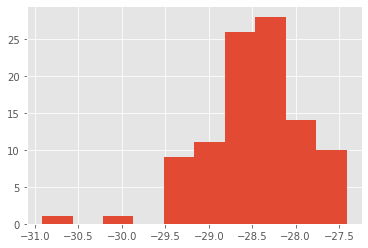

In [18]:
plt.hist(ent_est.raw_scores)

#### W. Batches

In [73]:
subsample = 40_000

ent_est = RBIGENTEST(batch_size=10_000)

ent_est.fit(base_df[:subsample])

h = ent_est.score(base_df[:subsample])

h

-31.84759524855099

In [74]:
ent_est.raw_scores

[-32.17903374504498,
 -31.753140917432507,
 -31.67399995592763,
 -31.784206375798846]

### Total Correlation, TC($X$)

In [78]:
subsample = 40_000

tc_est = RBIGMIEST(batch_size=None)

tc_est.fit(base_df[:subsample])

tc = tc_est.score(base_df[:subsample])

tc

51.735384060195784

#### w. Batches

In [79]:
subsample = 40_000

tc_est = RBIGMIEST(batch_size=10_000)

tc_est.fit(base_df[:subsample])

tc = tc_est.score(base_df[:subsample])

tc

50.6219155716329

In [80]:
tc_est.raw_scores

[50.29844313632438, 51.03391865505402, 50.72933249988033, 50.425967995272856]

### Mutual Information, MI($X$)

In [81]:
subsample = 100_000

mi_est = RBIGMIEST(batch_size=None)

mi_est.fit(
    base_df[:subsample],
    cmip_df[:subsample]
)

mi = mi_est.score(base_df[:subsample])

mi

1.2438747143982896

#### w. Batches

In [83]:
subsample = 100_000

mi_est = RBIGMIEST(batch_size=50_000)

mi_est.fit(
    base_df[:subsample],
    cmip_df[:subsample]
)

mi = mi_est.score(base_df[:subsample])

mi

1.215228412628969

In [84]:
mi_est.raw_values

AttributeError: 'RBIGEstimator' object has no attribute 'raw_values'

### Mutual Information II, H(X) + H(Y) - H(X,Y)

In [57]:
subsample = 100_000
batch_size = 25_000

# H(X)
print('H(X)')
x_ent_est = RBIGENTEST(batch_size=batch_size)

x_ent_est.fit(base_df.values[:subsample])

h_x = x_ent_est.score(base_df.values[:subsample])

# H(Y)
print('H(Y)')
y_ent_est = RBIGENTEST(batch_size=batch_size)

y_ent_est.fit(cmip_df.values[:subsample])

h_y = y_ent_est.score(cmip_df.values[:subsample])

# H(X,Y)
print('H(X,Y)')
xy_ent_est = RBIGENTEST(batch_size=50_000)

xy_ent_est.fit(
    np.hstack(
        (
            base_df.values[:subsample],
            cmip_df.values[:subsample]
        )
    ),
    
)

h_xy = xy_ent_est.score(base_df.values[:subsample])

H(X)
H(Y)
H(X,Y)


In [55]:
# H(X,Y)
print('H(X,Y)')
xy_ent_est = RBIGENTEST(batch_size=50_000)

xy_ent_est.fit(
    np.hstack(
        (
            base_df.values[:subsample],
            cmip_df.values[:subsample]
        )
    ),
    
)

h_xy = xy_ent_est.score(base_df.values[:subsample])
h_xy

H(X,Y)


165.23978712025018

In [58]:
h_x, h_y, h_xy, h_x + h_y - h_xy

(79.10616714936484, 87.19046271977632, 165.45410606367204, 0.8425238054691135)

0.4360788203771051

### Correlation: Pearson, Spearman, KendallTau

In [ ]:
pear = stats.pearsonr(
    base_df[:subsample].ravel(),
    cmip_df[:subsample].ravel(),
)

spear = stats.spearmanr(
    base_df[:subsample].ravel(),
    cmip_df[:subsample].ravel(),
)

kend = stats.kendalltau(
    base_df[:subsample].ravel(),
    cmip_df[:subsample].ravel(),
)

pear[0], spear[0], kend[0]